# Colon Cancer Detection using Deep Neural Networks






In [4]:
#Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
import tensorflow as tf
import zipfile
warnings.filterwarnings('ignore')

print('Setup Complete')

Setup Complete


In [5]:
#Extract zip files in the current directory
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [6]:
#Load both datasets and combine
main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')
combined_data = pd.concat([main_data,extra_data],axis = 0)

In [ ]:
#Split train, validation and test based on patient ID. 

from sklearn.model_selection import GroupShuffleSplit

#Create two splits and separate independent test set
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42).split(combined_data, groups=combined_data['patientID']))

train_data = combined_data.iloc[train_inds]
test_data = combined_data.iloc[test_inds]

#Create another split from training into train and validation set
train_ind, val_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42).split(train_data, groups=train_data['patientID']))

val_data  = train_data.iloc[val_inds]

train_data = train_data.iloc[train_ind]


print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 13176, Val Data: 3148, Test Data: 3956


In [ ]:
#Check whether there are any data leakage while splitting
print('Train and Test Set Intersection', (pd.Index(train_data).intersection(pd.Index(test_data))).values)
print('Train and Validation Set Intersection ', (pd.Index(train_data).intersection(pd.Index(val_data))).values)
print('Validation and Test Set Intersection ', (pd.Index(val_data).intersection(pd.Index(test_data))).values)

Train and Test Set Intersection []
Train and Validation Set Intersection  []
Validation and Test Set Intersection  []


In [ ]:
print('There are {} patients in Training Set'.format(len(train_data['patientID'].unique())))
print('There are {} patients in Validation Set'.format(len(val_data['patientID'].unique())))
print('There are {} patients in Test Set'.format(len(test_data['patientID'].unique())))

There are 62 patients in Training Set
There are 16 patients in Validation Set
There are 20 patients in Test Set


# Base MLP Model for Cancer Cell Detection

We decided to start with a simple neural network with 256 neurons as a base model. We used relu as a non-linear activation function due to it's computaional efficiency and softmax activation for output label. Using softmax or sigmoid produces the same results and the functions are quite the same.


In [ ]:
#Initiallize Input dimension, hidden layer and output classes
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2
#For better utlisation for cores
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
binary_model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='sigmoid')])

In [ ]:
binary_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


In [ ]:

#For Loss
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, title, metric_name='Accuracy'):
    plt.figure(figsize=(15,8))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    plt.suptitle(title)

    plt.show()

# For measuring F1-Score 
from keras import backend as K
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def plot_confusion_matrix(y_test,y_pred):

    conf_data = confusion_matrix(y_test,y_pred)
    df_cm = pd.DataFrame(conf_data, columns=np.unique(y_test), index = np.unique(y_test))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size

    return sns.heatmap(df_cm, cmap="Blues",annot=True,square=True,annot_kws={"size": 16},fmt="g");# font size

  
def model_result(X_train, X_val,model):
  
  # setup data some placeholders
  y_hat_all = list()
  y_all = list()
  y_pred_all = []
  y_true_all = []
  filenames = X_val.filenames
  train_images = len(X_train.filenames)
  N_images = len(filenames)
  batches = 0

  # iterate through the data generator and predict for each batch
  # hold the predictions and labels
  
  for x,y in X_val:
    y_hat = model.predict(x, verbose=0)
    y_hat = np.argmax(y_hat, axis = 1)
    y = np.argmax(y, axis = 1)
    y_hat_all = y_hat_all + y_hat.tolist()
    y_all = y_all + y.tolist()

    batches += 1
    if batches >= N_images / batch_size:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break
  
  for a,b in X_train:
    y_pred = model.predict(a,verbose = 0)
    y_pred = np.argmax(y_pred,axis = 1)
    b = np.argmax(b,axis = 1)
    y_pred_all = y_pred_all + y_pred.tolist()
    y_true_all = y_true_all + b.tolist()
    
    batches +=1
    if batches >= train_images / batch_size:
      break

  print("Training F1 score: ", f1_score(y_true_all, y_pred_all, average='macro'))
  print("Validation F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
  plot_confusion_matrix(y_all,y_hat_all)
  
  return pd.DataFrame(classification_report(y_all,y_hat_all,output_dict = True)).transpose()

In [ ]:
binary_model_1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy',f1])

In [ ]:
# Image Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')


train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 13090 validated image filenames belonging to 2 classes.
Found 3118 validated image filenames belonging to 2 classes.


In [ ]:
history_one = binary_model_1.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=1)

Epoch 1/100
165/412 [===========>..................] - ETA: 32:54 - loss: 0.6157 - binary_accuracy: 0.7133 - f1: 0.6948

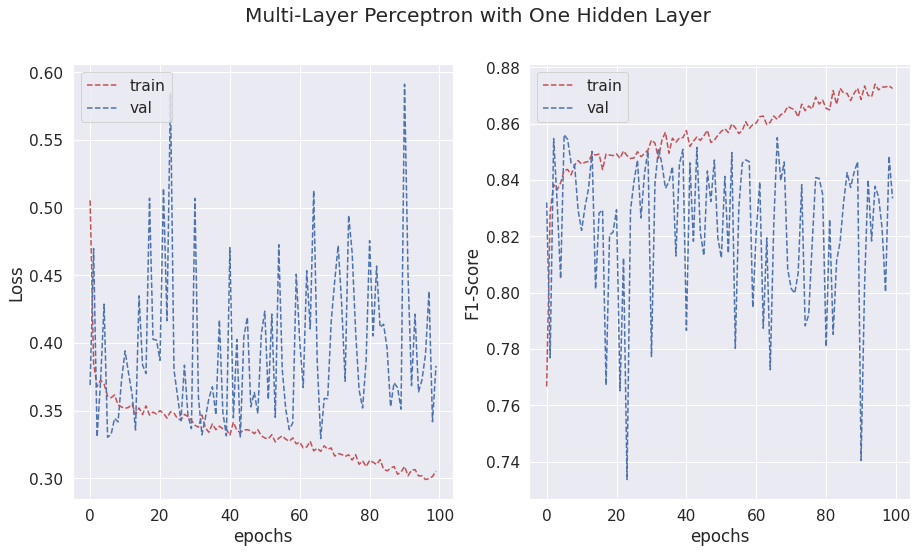

In [ ]:
plot_learning_curve(history_one.history['loss'], history_one.history['val_loss'], 
                    history_one.history['f1'], history_one.history['val_f1'], 'Multi-Layer Perceptron with One Hidden Layer',
                    metric_name='F1-Score')

Training F1 score:  0.8697209279175456
Validation F1 score:  0.810343075568589


,precision,recall,f1-score,support
0,0.936312,0.816756,0.872458,2232.000000
1,0.659450,0.864629,0.748229,916.000000
accuracy,0.830686,0.830686,0.830686,0.830686
macro avg,0.797881,0.840693,0.810343,3148.000000
weighted avg,0.855751,0.830686,0.836310,3148.000000


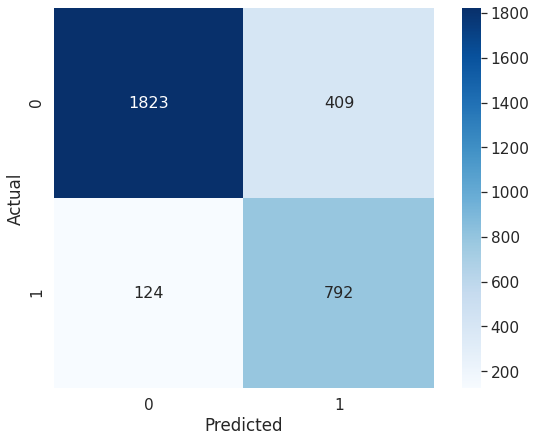

In [ ]:
model_result(train_generator,validation_generator,binary_model_1)

We observe difference between training score and validation score. In addition, the validation loss fluctuates at the same level indicating signs of overfitting. Also, looking at the traning score, we haven't obtained higher score so we decided to add one more layer and apply regularisaton on weights to balance the trade off.

In [ ]:
binary_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax')])

binary_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy',f1])

In [ ]:
binary_model.summary()

In [ ]:
history = binary_model.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=True)

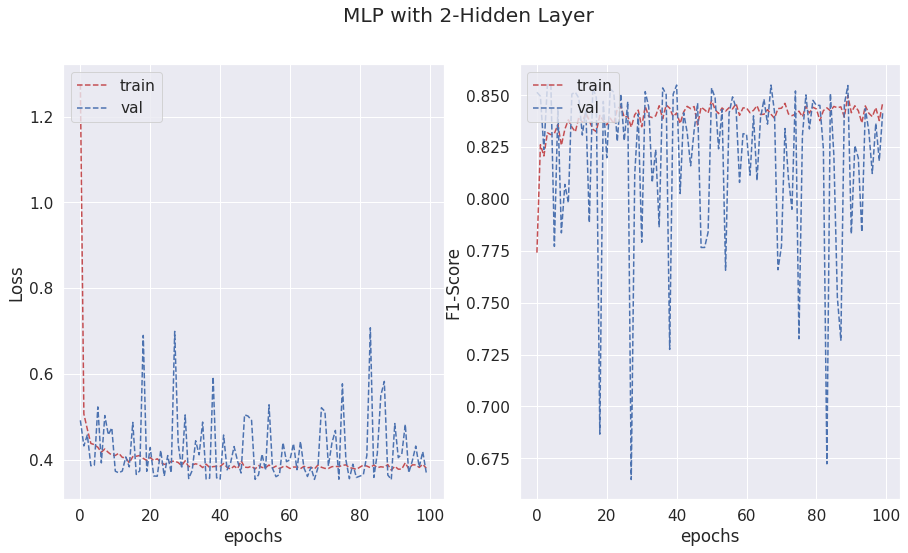

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['f1'], history.history['val_f1'], 'MLP with 2-Hidden Layer',
                    metric_name='F1-Score')

Training F1 score:  0.8393523633028644
Validation F1 score:  0.8151775810762323


,precision,recall,f1-score,support
0,0.914149,0.855092,0.883635,2229.000000
1,0.696143,0.805223,0.746720,919.000000
accuracy,0.840534,0.840534,0.840534,0.840534
macro avg,0.805146,0.830158,0.815178,3148.000000
weighted avg,0.850506,0.840534,0.843665,3148.000000


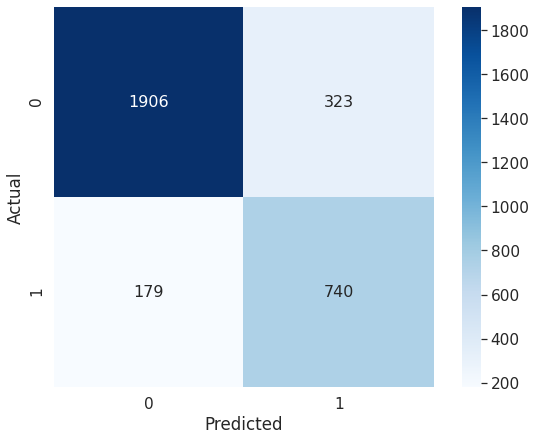

In [ ]:
model_result(train_generator,validation_generator,binary_model)

Looking at the loss curves, the model seems to perform quite well but also shows signs of underfitting. In comparison with two fully connected neural network, the latter model achieved better performance. Now, we decided further explore CNN models to capture features, reduce the dimensions and perform better than MLP models.

In [ ]:
binary_model_1.save('mlp_model_1')
binary_model.save('mlp_model_2')

INFO:tensorflow:Assets written to: ./drive/MyDrive/Image_classification_data/mlp_model_1/assets
INFO:tensorflow:Assets written to: ./drive/MyDrive/Image_classification_data/mlp_model_2/assets


In [19]:
#Apply MLP on test data 

test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

test_batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=test_batch_size,
        class_mode='categorical')

Found 3956 validated image filenames belonging to 2 classes.


In [ ]:
binary_model.evaluate(test_generator)

In [ ]:
y_hat_all = []
y_all = []
batches = 0
N_images = len(test_generator.filenames)
for x,y in test_generator:
    y_hat = binary_model.predict(x, verbose=0)
    y_hat = np.argmax(y_hat, axis = 1)
    y = np.argmax(y, axis = 1)
    y_hat_all = y_hat_all + y_hat.tolist()
    y_all = y_all + y.tolist()

    batches += 1
    if batches >= N_images / batch_size:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

Test F1 score:  0.8173119408970577


,precision,recall,f1-score,support
0,0.927622,0.862934,0.894109,2911.000000
1,0.680288,0.812440,0.740515,1045.000000
accuracy,0.849596,0.849596,0.849596,0.849596
macro avg,0.803955,0.837687,0.817312,3956.000000
weighted avg,0.862287,0.849596,0.853536,3956.000000


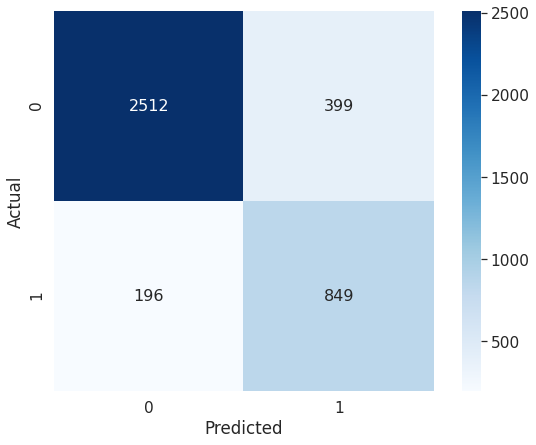

In [ ]:
print("Test F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
plot_confusion_matrix(y_all,y_hat_all)
pd.DataFrame(classification_report(y_all,y_hat_all,output_dict = True)).transpose()


## CNN for Colon Cancer Detection

We started with a VGG architecture but reduce the number of blocks due to our small image size. We train this model with a batch size of 32 from 100 epochs.

In [ ]:
# Base VGG
batch_size = 32
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax')
])

In [ ]:
model_VGG_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)        

In [ ]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy',f1])

In [ ]:
history_three = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=1)

In [ ]:
model_VGG_1.save("vgg_base_model")

INFO:tensorflow:Assets written to: ./drive/MyDrive/Image_classification_data/vgg_base_model/assets


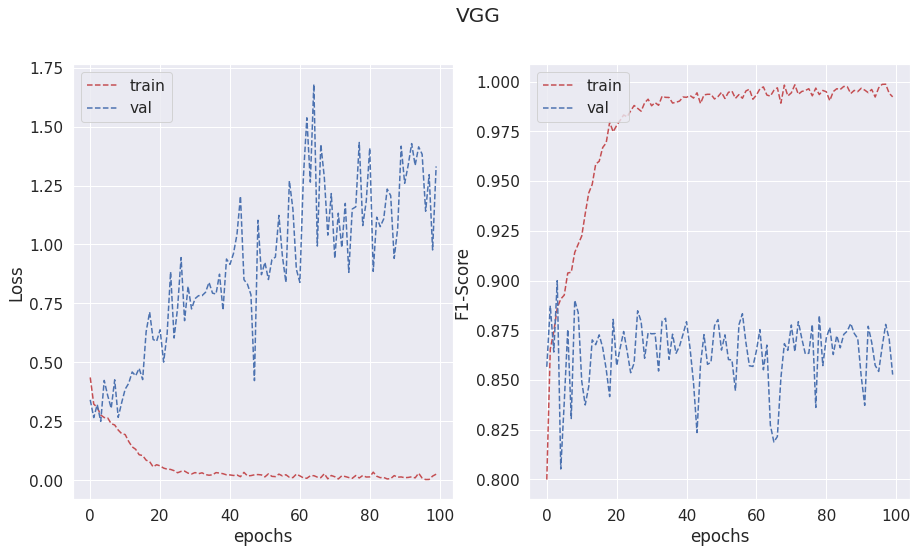

In [ ]:
plot_learning_curve(history_three.history['loss'], history_three.history['val_loss'], 
                    history_three.history['f1'], history_three.history['val_f1'], 'CNN (VGG) - Base Model ',
                    metric_name='F1-Score')

Training F1 score:  0.9985329062616816
Validation F1 score:  0.835902069468819


,precision,recall,f1-score,support
0,0.946835,0.840827,0.890688,2224.000000
1,0.698210,0.886364,0.781116,924.000000
accuracy,0.854193,0.854193,0.854193,0.854193
macro avg,0.822523,0.863595,0.835902,3148.000000
weighted avg,0.873859,0.854193,0.858527,3148.000000


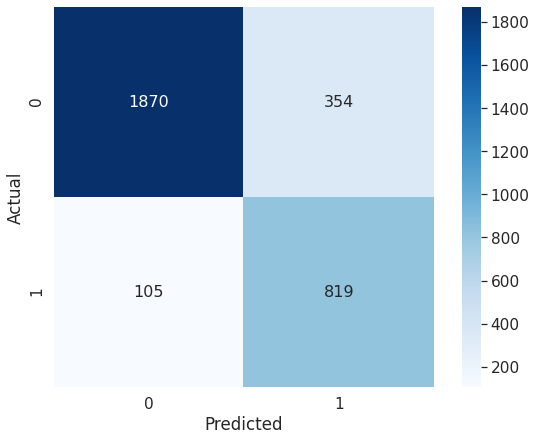

In [ ]:
model_result(train_generator, validation_generator,model_VGG_1)

Looking at the results, we observe that model is highly overfitted therefore we decide to augment data and apply regularisations.

# Data Augmentation and Weight Regularization


In [ ]:
#Rotate image to 45 degrees,shift width and height by 0.2, change brightness, apply shear, horizontal flips and vertical flips 

train_datagen_aug = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                       rotation_range=45, width_shift_range=0.2,height_shift_range=0.2, shear_range = 0.2,horizontal_flip=True,vertical_flip=True)

batch_size = 32

train_generator_aug = train_datagen_aug.flow_from_dataframe(
        dataframe=train_data,
        directory='patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 13090 validated image filenames belonging to 2 classes.


In [ ]:
#Improvement on VGG 


model_VGG_2 = tf.keras.Sequential([
    
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax')
])

In [ ]:
model_VGG_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)        

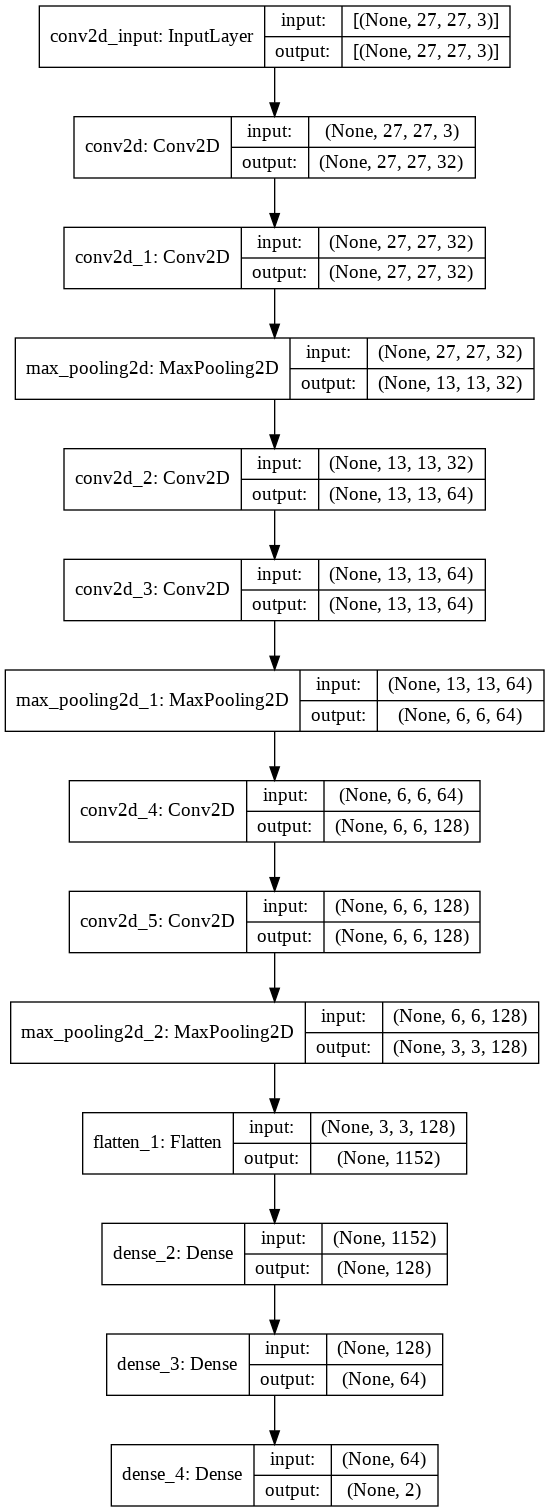

In [ ]:
tf.keras.utils.plot_model(model_VGG_2, show_shapes=True)

In [ ]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy',f1])

In [ ]:
history_vgg_2 = model_VGG_2.fit_generator(train_generator_aug, validation_data = validation_generator, epochs=100, verbose=1)

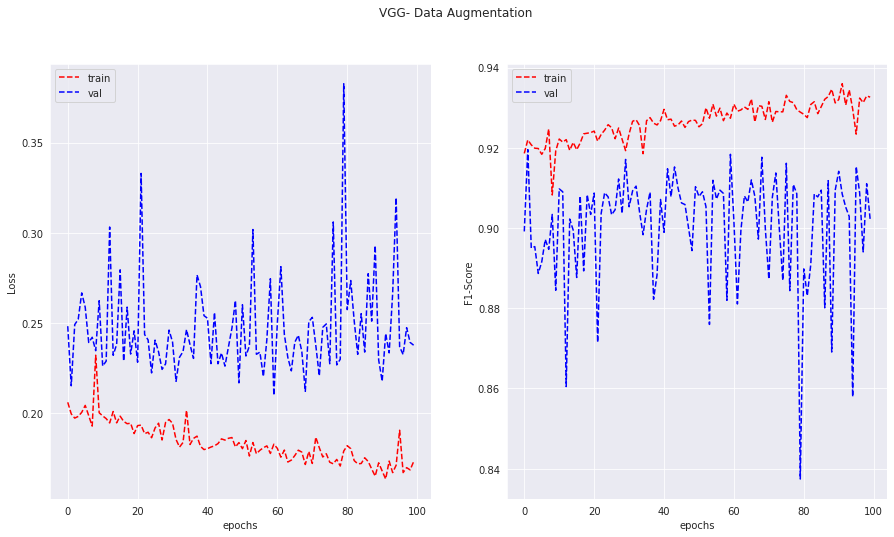

In [15]:
plot_learning_curve(history_vgg_2.history['loss'], history_vgg_2.history['val_loss'], 
                    history_vgg_2.history['f1'], history_vgg_2.history['val_f1'], 'VGG- Data Augmentation', metric_name='F1-Score')

Training F1 score:  0.9218849168187029
Validation F1 score:  0.8879913226923046


,precision,recall,f1-score,support
0,0.929553,0.941652,0.935563,2228.000000
1,0.854097,0.827174,0.840420,920.000000
accuracy,0.908196,0.908196,0.908196,0.908196
macro avg,0.891825,0.884413,0.887991,3148.000000
weighted avg,0.907501,0.908196,0.907757,3148.000000


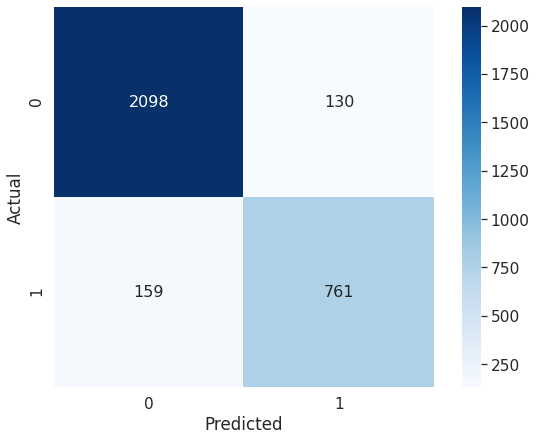

In [ ]:
model_result(train_generator_aug, validation_generator,model_VGG_2)

In [20]:
model_VGG_2.evaluate(test_generator)

3956/3956 [==============================] - 1230s 311ms/step - loss: 0.2729 - binary_accuracy: 0.8923 - f1: 0.8923


[0.2728881239891052, 0.8923154473304749, 0.8923153877258301]

Test F1 score:  0.869770072840405


,precision,recall,f1-score,support
0,0.961010,0.889653,0.923956,2909.000000
1,0.745843,0.899713,0.815584,1047.000000
accuracy,0.892315,0.892315,0.892315,0.892315
macro avg,0.853427,0.894683,0.869770,3956.000000
weighted avg,0.904064,0.892315,0.895274,3956.000000


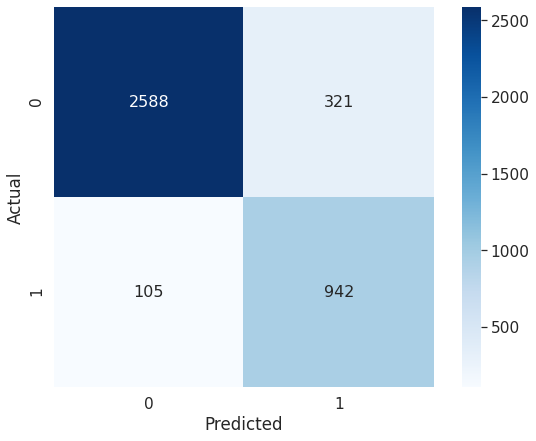

In [21]:
y_hat_all = []
y_all = []
batches = 0
N_images = len(test_generator.filenames)
for x,y in test_generator:
    y_hat = model_VGG_2.predict(x, verbose=0)
    y_hat = np.argmax(y_hat, axis = 1)
    y = np.argmax(y, axis = 1)
    y_hat_all = y_hat_all + y_hat.tolist()
    y_all = y_all + y.tolist()

    batches += 1
    if batches >= N_images / test_batch_size:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

print("Test F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
plot_confusion_matrix(y_all,y_hat_all)
pd.DataFrame(classification_report(y_all,y_hat_all,output_dict = True)).transpose()


In [ ]:
model_VGG_2.save('vgg_model_2_aug')

INFO:tensorflow:Assets written to: ./drive/MyDrive/Image_classification_data/vgg_model_2_aug/assets


In [ ]:
model_VGG_2.save_weights('vgg_model_2_wts')

After transforming the data with various augmentation technique, we were able to achieve higher traning and validatin f1-score. Further evidence from confusion matrix and classification report indicates that this model was able to perform well on validation set. We use this model to evaluate our independent test, which performed well with a macro average f1-score of 86. However, we still want to reduce the gap between training and validation and minimize the loss. For this purpose, we then appled regularisation and dropouts but it decrease the validation performance. After all the necessary experiments

In [22]:
#Improvement on VGG through weight regularization

reg_lambda = 0.0001

model_VGG_3 = tf.keras.Sequential([
    
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax')
])

In [ ]:
model_VGG_3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 6, 6, 128)        

In [25]:
model_VGG_3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy',f1])

In [ ]:
history_vgg_3 = model_VGG_3.fit_generator(train_generator_aug, validation_data = validation_generator, epochs=100, verbose=1)

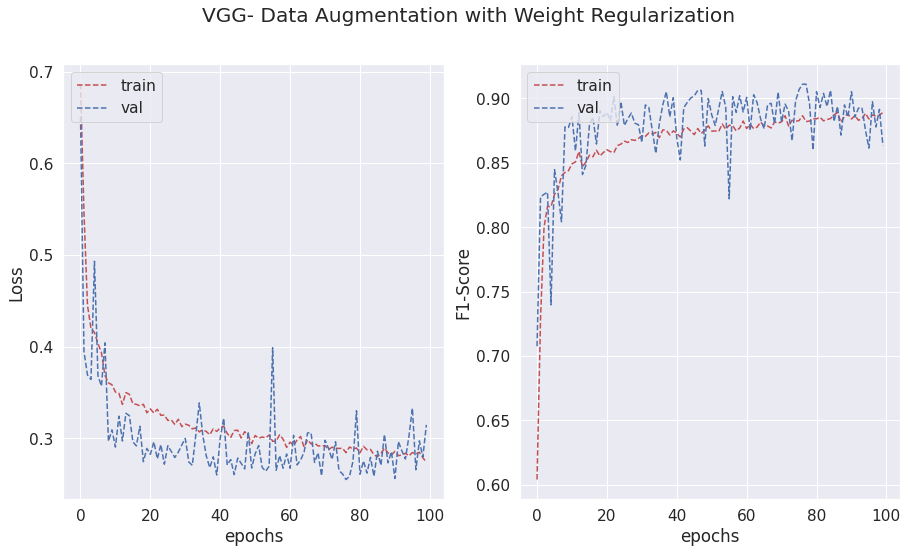

In [ ]:
plot_learning_curve(history_vgg_3.history['loss'], history_vgg_3.history['val_loss'], 
                    history_vgg_3.history['f1'], history_vgg_3.history['val_f1'], 'VGG- Data Augmentation with Weight Regularization',
                    metric_name='F1-Score')

Training F1 score:  0.8880471358269372
Validation F1 score:  0.8438516437298924


,precision,recall,f1-score,support
0,0.940284,0.862208,0.899555,2228.000000
1,0.722172,0.867391,0.788148,920.000000
accuracy,0.863723,0.863723,0.863723,0.863723
macro avg,0.831228,0.864800,0.843852,3148.000000
weighted avg,0.876541,0.863723,0.866997,3148.000000


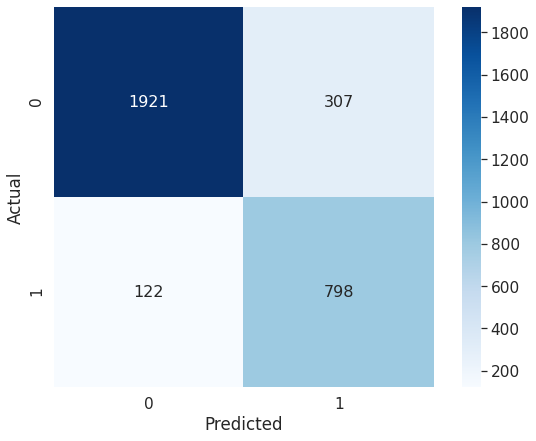

In [ ]:
model_result(train_generator_aug, validation_generator,model_VGG_3)

In [ ]:
#Improvement on VGG through weight regularization

reg_lambda = 0.001

model_VGG_4 = tf.keras.Sequential([
    
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax')
])

In [ ]:
model_VGG_4.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy',f1])

In [ ]:
history_vgg_4 = model_VGG_4.fit_generator(train_generator_aug, validation_data = validation_generator, epochs=100, verbose=1)

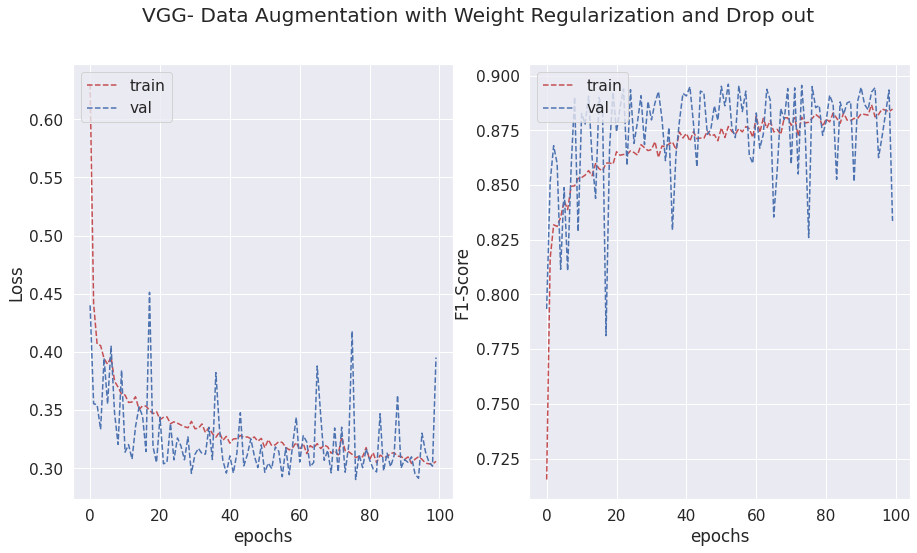

In [ ]:
plot_learning_curve(history_vgg_4.history['loss'], history_vgg_4.history['val_loss'], 
                    history_vgg_4.history['f1'], history_vgg_4.history['val_f1'], 'VGG- Data Augmentation with Weight Regularization and Drop out',
                    metric_name='F1-Score')

Training F1 score:  0.8610422362739811
Validation F1 score:  0.8156822992648531


,precision,recall,f1-score,support
0,0.948421,0.808797,0.873062,2228.000000
1,0.658654,0.893478,0.758303,920.000000
accuracy,0.833545,0.833545,0.833545,0.833545
macro avg,0.803537,0.851138,0.815682,3148.000000
weighted avg,0.863737,0.833545,0.839524,3148.000000


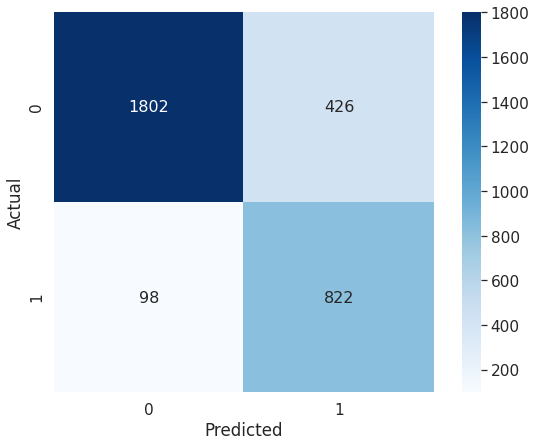

In [ ]:
model_result(train_generator_aug, validation_generator,model_VGG_4)